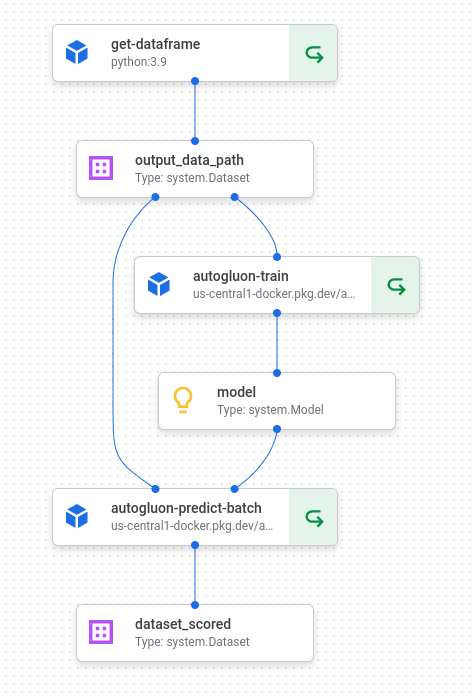

In [ ]:
# imports for this notebook to run
import sys
from datetime import datetime
from typing import NamedTuple

from google.cloud import aiplatform as vertex

import kfp
from kfp.v2 import dsl, compiler

In [ ]:
# specify parameters
PROJECT_ID = "yourproject"
REGION = "us-central1"
BUCKET_NAME = f"bkt-{PROJECT_ID}-vpipelines"
BUCKET_PATH = f"gs://{BUCKET_NAME}"
PIPELINE_ROOT = f"{BUCKET_PATH}/pipeline_root"
PIPELINE_DATA = f"{BUCKET_PATH}/data"
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [ ]:
# Download BigQuery data and convert to CSV
@dsl.component(
    packages_to_install=["google-cloud-bigquery", "pandas", "pyarrow", "db-dtypes"],
    base_image="python:3.9",
    output_component_file="component_create_dataset.yaml"
)
def get_dataframe(
    bq_table: str,
    output_data_path: dsl.OutputPath("Dataset")
):
    from google.cloud import bigquery
    import pandas as pd
    import os

    project_number = os.environ["CLOUD_ML_PROJECT_ID"]
    bqclient = bigquery.Client(project=project_number)
    table = bigquery.TableReference.from_string(
        bq_table
    )
    rows = bqclient.list_rows(
        table
    )
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2, replace=True)
    
    dataframe.to_csv(output_data_path)
    output_data_path = output_data_path + ".csv"

In [ ]:
# autogluon container - train
@dsl.component(
    base_image="us-central1-docker.pkg.dev/ap-alto-ml-1000/ap-docker-repo/autogluon_0.5.2-cpu-framework-ubuntu20.04-py3.8:latest",
    output_component_file="component_autogluon_train.yaml"
)
def autogluon_train(
    dataset: dsl.Input[dsl.Dataset]
    , model: dsl.Output[dsl.Model]
):
    
    # build the default autogluon model
    from autogluon.tabular import TabularDataset, TabularPredictor
    
    label = 'label'
    train_data = TabularDataset(dataset.path)
    predictor = TabularPredictor(label=label, path=model.path).fit(train_data)
    model.uri = model.uri  + "/predictor.pkl"

In [ ]:
# autogluon container - batch predict
@dsl.component(
    base_image="us-central1-docker.pkg.dev/ap-alto-ml-1000/ap-docker-repo/autogluon_0.5.2-cpu-framework-ubuntu20.04-py3.8:latest"
    , packages_to_install=["protobuf==3.18.1"]
    , output_component_file="component_autogluon_predict_batch.yaml"
)
def autogluon_predict_batch(
    model: dsl.Input[dsl.Model]
    , dataset: dsl.Input[dsl.Dataset]
    , dataset_scored: dsl.OutputPath("Dataset")
):
    
    from autogluon.tabular import TabularDataset, TabularPredictor
    
    # load model
    predictor = TabularPredictor.load(model.path.replace("/predictor.pkl",""))
    
    # load data
    test_data = TabularDataset(dataset.path)
    
    # score data
    scored = predictor.predict(test_data.drop(columns=["label"]))
    scored.to_csv(dataset_scored)

In [ ]:
#####################################################################
#
# define the pipeline
#
#####################################################################

In [ ]:
# define a pipeline
@dsl.pipeline(name="autogluon-testing", description="my pipeline description")

# specify all the inputs the pipeline needs to run
def my_pipeline(
    bq_table: str = ""
    , output_data_path: str = "data.csv"
    , project_id: str = PROJECT_ID
    , region: str = REGION
):
        
    # specify the nodes in the pipeline
    dataset_task = get_dataframe(bq_table)

    model_task = autogluon_train(dataset_task.output)
    
    predict_task = autogluon_predict_batch(model_task.output, dataset_task.output)

In [ ]:
#####################################################################
#
# compile and run the pipeline
#
#####################################################################

In [ ]:
# compile the pipeline
my_package_path = 'my_vertex_pipeline_specification_file.json'
compiler.Compiler().compile(pipeline_func=my_pipeline, package_path=my_package_path)

In [ ]:
# runtime parameters to pass to pipeline
pipeline_params = {"bq_table": "your_project.your_ds.your_table"}

# run the pipeline
vertex.init(project=PROJECT_ID)

job = vertex.PipelineJob(
    display_name = "my-pipeline-job-name",
    template_path = my_package_path,
    pipeline_root = PIPELINE_ROOT,
    parameter_values = pipeline_params,
    enable_caching = True
)

job.submit()